yfinance: https://pypi.org/project/yfinance/

# Import packages

In [48]:
# import and (if needed) install required package

#!pip install requests
#!pip install requests_html
#!pip install mplfinance

try:
    import pandas as pd
except:
    !pip install pandas
    import pandas as pd

# try:
#     from yahoo_fin import stock_info as si
#     from yahoo_fin import news
# except:
#     !pip install yahoo_fin
#     from yahoo_fin import stock_info as si
#     from yahoo_fin import news

try:
    import yfinance as yf
except:
    !pip install yfinance
    import yfinance as yf

try:
    from mplfinance.original_flavor import candlestick_ohlc
except:
    !pip install mplfinance
    from mplfinance.original_flavor import candlestick_ohlc
    
try:
    import plotly.graph_objects as go
    import plotly.subplots as ms
except:
    !pip install plotly
    import plotly.graph_objects as go
    import plotly.subplots as ms
    
try:
    from datetime import datetime
except:
    !pip install datetime
    from datetime import datetime
try:
    from ta import add_all_ta_features
    from ta.utils import dropna
except:
    !pip install ta #pandas_ta
    from ta import add_all_ta_features
    from ta.utils import dropna    
try:
    from scipy.signal import savgol_filter as smooth
except:
    !pip install scipy
    from scipy.signal import savgol_filter as smooth

try:
    import trendln
except:
    !pip install trendln
    import trendln

    
    
import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings('ignore')

# Load Treasury Yield 10 Years

[*********************100%***********************]  1 of 1 completed


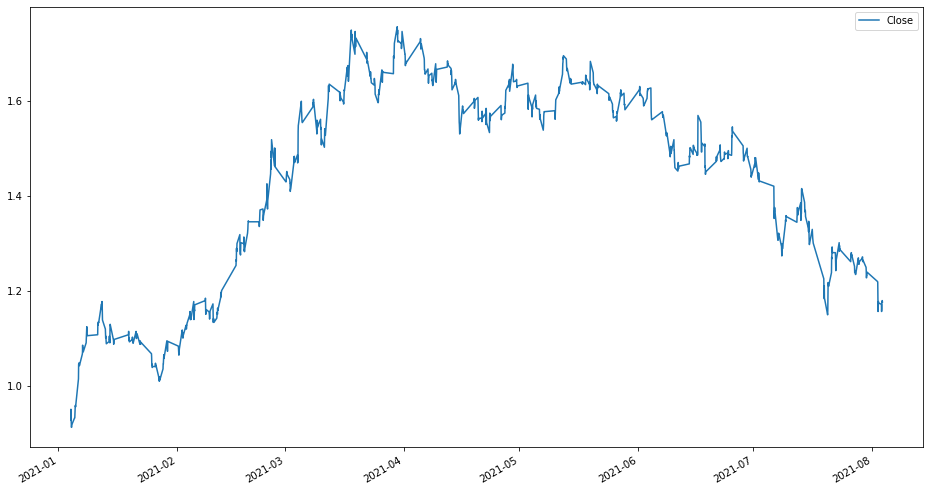

In [49]:
TNX_data = yf.download('^TNX', period='ytd', interval = "1h");
TNX_data.plot(y=['Close'], figsize=(16,9));

In [50]:
TNX_data = yf.download('^TNX', period='5d', interval = "15m")
fig = go.Figure(data=[go.Candlestick(x=TNX_data.index,
                open=TNX_data['Open'],
                high=TNX_data['High'],
                low=TNX_data['Low'],
                close=TNX_data['Close'])])
fig.show()

[*********************100%***********************]  1 of 1 completed


# Chart Analysis

In [51]:
#Define the symbol and period:

ticker='^GDAXI'
# DAX: '^GDAXI'
# NASDAQ-100: '^IXIC'
# S&P500: '^GSPC'
# Dow Jones: '^DJI'
# DB German Bund Futures ETN: 'BUNL'
# AEX: '^AEX'
# FTSE 100: '^FTSE'
# CAC 40 ^FCHI'

period='3mo'
# valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max

interval='1d'
# valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo

In [52]:
df = yf.download(ticker, period=period, interval=interval);

[*********************100%***********************]  1 of 1 completed


In [53]:
df = df.reset_index()

In [54]:
if interval=='1mo' :
    df=df[df[df.columns[0]]>='2019-01-01']
elif interval=='1wk':
    df=df[df[df.columns[0]]>='2020-01-01']

In [55]:
##Make Subplot of 2 rows to plot 2 graphs sharing the x axis

fig = ms.make_subplots(rows=2,
                       cols=1,
                       shared_xaxes=True,
                       vertical_spacing=0.02)

##Add Candlstick Chart to Row 1 of subplot

fig.add_trace(go.Candlestick(x=df[df.columns[0]],
                             open=df['Open'],
                             high=df['High'],
                             low=df['Low'],
                             close=df['Close'],
                             increasing_line_color='green',
                             decreasing_line_color='red'),
              row=1,
              col=1)

#Add Volume Chart to Row 2 of subplot
fig.add_trace(go.Bar(x=df[df.columns[0]], y=df['Volume']), row=2, col=1)

#Update Price Figure layout
if get_ipython(
).__class__.__name__ == 'ZMQInteractiveShell':  #Check if the code is running in Jupyter Notebook
    fig.update_layout(title='Interactive CandleStick & Volume Chart',
                      yaxis1_title='Stock Price',
                      yaxis2_title='Volume (M)',
                      xaxis2_title='Time',
                      xaxis1_rangeslider_visible=False,
                      xaxis2_rangeslider_visible=True)

fig.show()

In [56]:
# Add ta features filling NaN values
df_ta_features = add_all_ta_features(df,
                                     open="Open",
                                     high="High",
                                     low="Low",
                                     close="Close",
                                     volume="Volume",
                                     fillna=True)



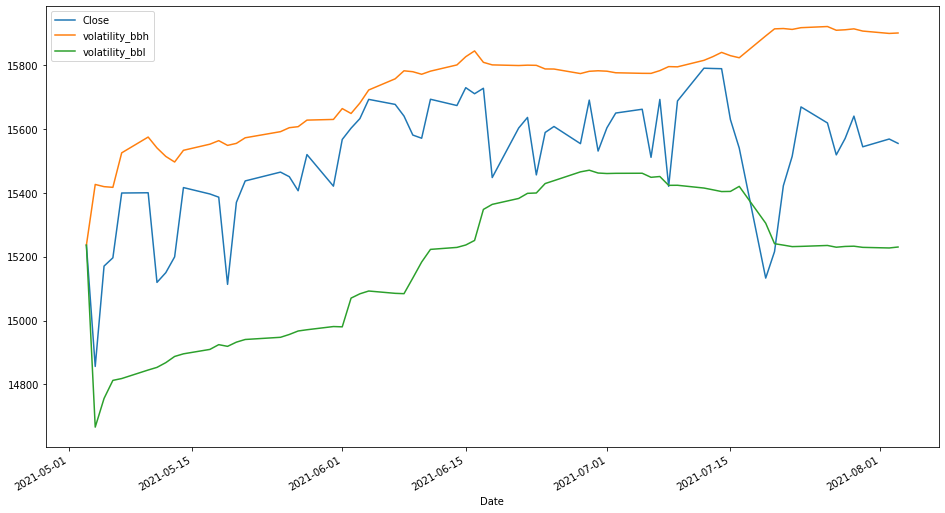

In [57]:
df_ta_features.plot(x=df_ta_features.columns[0],
                    y={'Close', 'volatility_bbl', 'volatility_bbh'},
                    figsize=(16, 9));

Draw support and resistance Lines

link: https://github.com/gianlucamalato/machinelearning/blob/master/Support_and_resistance.ipynb

In [58]:
df['Date'] = df['Date'].apply(mpl_dates.date2num)

df = df.loc[:,['Date', 'Open', 'High', 'Low', 'Close']]


In [59]:
def isSupport(df,i):
    support = df['Low'][i] < df['Low'][i-1]  and df['Low'][i] < df['Low'][i+1] \
    and df['Low'][i+1] < df['Low'][i+2] and df['Low'][i-1] < df['Low'][i-2]

    return support


def isResistance(df,i):
    resistance = df['High'][i] > df['High'][i-1]  and df['High'][i] > df['High'][i+1] \
    and df['High'][i+1] > df['High'][i+2] and df['High'][i-1] > df['High'][i-2] 

    return resistance

In [60]:
levels = []
for i in range(2,df.shape[0]-2):
    if isSupport(df,i):
        levels.append((i,df['Low'][i]))
    elif isResistance(df,i):
        levels.append((i,df['High'][i]))

In [61]:
def plot_all():
    fig, ax = plt.subplots()

    candlestick_ohlc(ax,df.values,width=0.6, \
                     colorup='green', colordown='red', alpha=0.8)

    date_format = mpl_dates.DateFormatter('%d %b %Y')
    ax.xaxis.set_major_formatter(date_format)
    fig.autofmt_xdate()

    fig.tight_layout()

    for level in levels:
        plt.hlines(level[1],xmin=df['Date'][level[0]],\
                   xmax=max(df['Date']),colors='blue')
    fig.show()

In [62]:
levels

[(5, 15419.4296875),
 (12, 14961.26953125),
 (15, 15568.599609375),
 (24, 15732.0595703125),
 (29, 15802.669921875),
 (40, 15752.9296875),
 (54, 15048.5595703125),
 (58, 15681.41015625),
 (60, 15423.5595703125)]

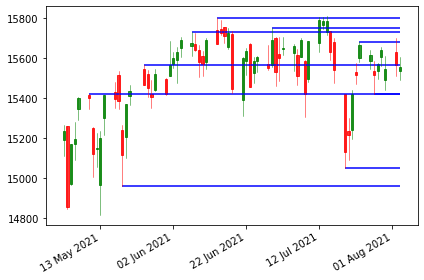

In [63]:
plot_all()

In [64]:
s =  np.mean(df['High'] - df['Low'])

In [65]:
def isFarFromLevel(l):
    return np.sum([abs(l-x) < s  for x in levels]) == 0

In [66]:
levels = []
for i in range(2,df.shape[0]-2):
    if isSupport(df,i):
        l = df['Low'][i]

        if isFarFromLevel(l):
            levels.append((i,l))

    elif isResistance(df,i):
        l = df['High'][i]

        if isFarFromLevel(l):
            levels.append((i,l))

In [67]:
levels

[(5, 15419.4296875), (12, 14961.26953125), (24, 15732.0595703125)]

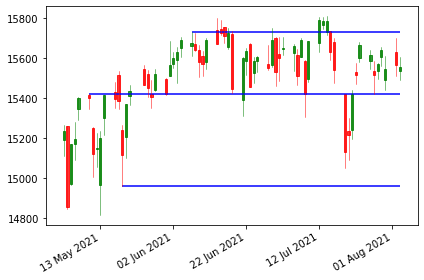

In [68]:
plot_all()

In [69]:
#Another code: https://kite.trade/forum/discussion/1047/a-simple-python-function-to-detect-support-resistance-levels

In [70]:
#Draw Trendlines

In [71]:
# # this will serve as an example for security or index closing prices, or low and high prices
# import yfinance as yf # requires yfinance - pip install yfinance
# tick = yf.Ticker('^GSPC') # S&P500
# hist = tick.history(period="max", rounding=True)
# h = hist[-1000:].Close
# mins, maxs = trendln.calc_support_resistance(h, accuracy=8)
# minimaIdxs, pmin, mintrend, minwindows = trendln.calc_support_resistance((hist[-1000:].Low, None), accuracy=8) #support only
# mins, maxs = trendln.calc_support_resistance((hist[-1000:].Low, hist[-1000:].High), accuracy=8)
# (minimaIdxs, pmin, mintrend, minwindows), (maximaIdxs, pmax, maxtrend, maxwindows) = mins, maxs

In [72]:
# trendln.plot_sup_res_learn('.', hist)

In [73]:
# Candlestick pattern recognition

In [74]:
#order book (later)

In [75]:
# present the important indicators such as macd 

In [76]:
#others (later)

In [77]:
# youtube: https://www.youtube.com/watch?v=WM-V9qFCkJc

In [78]:
### https://www.backtrader.com/docu/installation/

In [79]:
#trading strategy: https://github.com/vahidtabatabaie/finance_datacamp_code/blob/master/Python%20Finance%20Tutorial%20For%20Beginners/Python%20For%20Finance%20Beginners%20Tutorial.ipynb

In [80]:
#!pip install investpy
import investpy

search_result = investpy.search_quotes(text='apple', products=['stocks'],
                                       countries=['united states'], n_results=1)
print(search_result)

{"id_": 6408, "name": "Apple Inc", "symbol": "AAPL", "country": "united states", "tag": "/equities/apple-computer-inc", "pair_type": "stocks", "exchange": "NASDAQ"}


In [81]:
recent_data = search_result.retrieve_recent_data() #https://pypi.org/project/investpy/
print(recent_data.head())

              Open    High     Low   Close     Volume  Change Pct
Date                                                             
2021-07-06  140.17  143.11  140.15  142.02  108181792        1.47
2021-07-07  143.58  144.88  142.74  144.57  104911592        1.80
2021-07-08  141.49  144.05  140.69  143.24  105575456       -0.92
2021-07-09  142.75  145.65  142.65  145.11   99891000        1.31
2021-07-12  146.22  146.22  144.04  144.50   76299720       -0.42


In [86]:
#Order book: 

### Volume

In [83]:
import json
import datetime
import requests
from bs4 import BeautifulSoup

url = 'https://www.investing.com/common/modules/js_instrument_chart/api/data.php?pair_id=172&pair_id_for_news=172&chart_type=candlestick&pair_interval=300&candle_count=120&events=yes&volume_series=yes&period='
headers = {
    'User-Agent':
    'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:81.0) Gecko/20100101 Firefox/81.0',
    'X-Requested-With': 'XMLHttpRequest',
    'Referer': 'https://www.investing.com/indices/germany-30'
}
data = requests.get(url, headers=headers).json()

# uncomment this to print all data:
# print( json.dumps(data, indent=4) )

for candle in data['candles']:
    t = datetime.datetime.fromtimestamp(candle[0] // 1000)
    print('{!s:<20} {:<10} {:<10} {:<10} {:<10} {:<10}'.format(t, *candle[1:]))

2021-08-02 16:15:00  15577.55   15583.75   15567.9    15569.35   314966    
2021-08-02 16:20:00  15570.8    15578.15   15564      15570.45   310929    
2021-08-02 16:25:00  15572.75   15587.9    15569.8    15587.5    317354    
2021-08-02 16:30:00  15588.5    15593.95   15586.75   15593.1    332514    
2021-08-02 16:35:00  15592.8    15596.25   15589.9    15591      254201    
2021-08-02 16:40:00  15590.75   15590.95   15570.75   15570.75   369669    
2021-08-02 16:45:00  15569.75   15583.8    15568      15582.85   283009    
2021-08-02 16:50:00  15582.35   15590.9    15581.95   15590.75   354347    
2021-08-02 16:55:00  15587      15587      15581.35   15584.8    308347    
2021-08-02 17:00:00  15586.2    15594.35   15580.35   15592.95   385064    
2021-08-02 17:05:00  15592.7    15594.8    15590.8    15592.05   375501    
2021-08-02 17:10:00  15591.75   15598.3    15586.85   15586.85   476508    
2021-08-02 17:15:00  15586      15586.75   15576.35   15579.95   624634    
2021-08-02 1

In [84]:
data['candles']

[[1627913700000, 15577.55, 15583.75, 15567.9, 15569.35, 314966, 0],
 [1627914000000, 15570.8, 15578.15, 15564, 15570.45, 310929, 0],
 [1627914300000, 15572.75, 15587.9, 15569.8, 15587.5, 317354, 0],
 [1627914600000, 15588.5, 15593.95, 15586.75, 15593.1, 332514, 0],
 [1627914900000, 15592.8, 15596.25, 15589.9, 15591, 254201, 0],
 [1627915200000, 15590.75, 15590.95, 15570.75, 15570.75, 369669, 0],
 [1627915500000, 15569.75, 15583.8, 15568, 15582.85, 283009, 0],
 [1627915800000, 15582.35, 15590.9, 15581.95, 15590.75, 354347, 0],
 [1627916100000, 15587, 15587, 15581.35, 15584.8, 308347, 0],
 [1627916400000, 15586.2, 15594.35, 15580.35, 15592.95, 385064, 0],
 [1627916700000, 15592.7, 15594.8, 15590.8, 15592.05, 375501, 0],
 [1627917000000, 15591.75, 15598.3, 15586.85, 15586.85, 476508, 0],
 [1627917300000, 15586, 15586.75, 15576.35, 15579.95, 624634, 0],
 [1627917600000, 15581.65, 15598.55, 15580.8, 15598.35, 631769, 0],
 [1627917900000, 15597.75, 15597.75, 15585.9, 15586.85, 635736, 0],
 [

In [85]:
# https://github.com/FPSUsername/ING-Sprinters

In [ ]:
#Fib and pivot and other metrics from investpy